In [93]:
'''
DATA PREPROCESSING/EXPLORATION STEP
'''

'''
Implement data augmentation on Waldo images using Keras
'''
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.datasets import load_files
from glob import glob
import numpy as np
import cv2
from keras.models import load_model
from keras.preprocessing import image                  
from tqdm import tqdm # Used for the progress bar visualization
import random
from keras.callbacks import ModelCheckpoint

# Declare the data generation object for data augmentation
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255, # rescale the image before feeding it to the cnn
        shear_range=0.2,
        zoom_range=0.5,
        horizontal_flip=True,
        fill_mode='nearest')

In [94]:
'''
Generate augmented images for waldo (do it only once)
'''

# waldo_filenames = np.array(glob("waldo_dataset/original_waldo/*"))
# for filename in waldo_filenames:
#     img = load_img(filename)
#     x = img_to_array(img)
#     x = x.reshape((1,) + x.shape)
#     i = 0
#     for batch in datagen.flow(x, batch_size=1,
#                               save_to_dir='waldo_dataset/train_32/waldo', 
#                               save_prefix='new_waldo', 
#                               save_format='jpg'):
#         i += 1
#         if i > 20:
#             break  # the flow may yield batches indefinitely


'\nGenerate augmented images for waldo (do it only once)\n'

In [95]:
# The following function loads a data set along with the targets 
# Note that the directory has to have at least two folders containing different classes
# The following function was taken from dog breed classification project
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    return files, targets

# Declare the training (all_files) and test datasets along with their labels
all_files, all_targets = load_dataset('waldo_dataset/train_32')
test_files, test_targets = load_dataset('waldo_dataset/test')


# Shuffle the data to avoid a bias
rand = np.random.RandomState(10)
shuffle = rand.permutation(len(all_files))
all_files, all_targets = all_files[shuffle], all_targets[shuffle]


# Show statistics about the data
waldoFiles = np.array(glob("waldo_dataset/train_32/waldo/*"))
notWaldoFiles = np.array(glob("waldo_dataset/train_32/notwaldo/*"))
print('Waldo dataset contains ' + str(len(waldoFiles)) + ' images')
print('Notwaldo dataset contains ' + str(len(notWaldoFiles)) + ' images')

Waldo dataset contains 604 images
Notwaldo dataset contains 5337 images


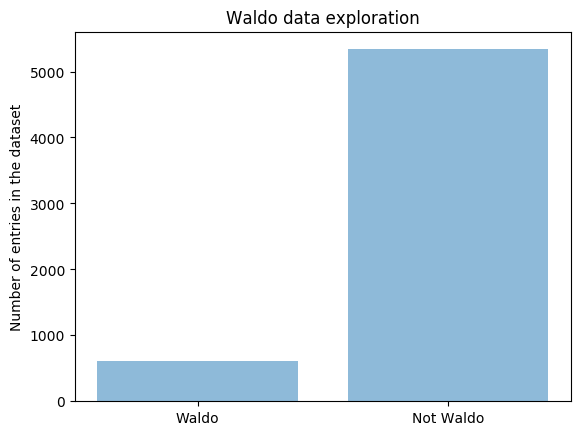

In [96]:
# Use it tov visualize the data
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
 
objects = ('Waldo', 'Not Waldo')
y_pos = np.arange(len(objects))
performance = [len(waldoFiles), len(notWaldoFiles)]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Number of entries in the dataset')
plt.title('Waldo data exploration')
 
plt.show()

In [97]:
# Use this function to resize an image into 32x32 size
def resize_img(filename, key):
    image = cv2.imread(filename)
    r = 100.0 / image.shape[1]
    dim = (100, int(image.shape[0] *r))
    imageresized = cv2.resize(image,(32,32),dim,interpolation = cv2.INTER_AREA)
    cv2.imwrite('imageresized_{}.jpg'.format(key), imageresized)
    
# Use this code to resize all the images in the directory (use it only once)
# waldoFilesnew = np.array(glob("waldo_dataset/test/waldo/*"))
# key = 0    
# for image_file in waldoFilesnew:
#     resize_img(image_file, key)
#     key += 1

In [127]:
'''
CREATE THE SVM CLASSIFIER
'''
from skimage.feature import hog
import skimage as skimage

# Calculate HOGs for all the images in the training set
hog_descriptors = []
for img in all_files:
    timg = skimage.color.rgb2grey(cv2.imread(img))
    hog_descriptors.append(hog(timg, orientations=9, pixels_per_cell=(8, 8), 
                                      cells_per_block=(3, 3), 
                                      visualise=False, 
                                      transform_sqrt=False, 
                                      feature_vector=True, 
                                      normalise=None))

# Calculate HOGs for all the images in the testing set
hog_descriptors_test = []
for img in test_files:
    timg = skimage.color.rgb2grey(cv2.imread(img))
    hog_descriptors_test.append(skimage.feature.hog(timg, orientations=9, pixels_per_cell=(8, 8), 
                                      cells_per_block=(3, 3), 
                                      visualise=False, 
                                      transform_sqrt=False, 
                                      feature_vector=True, 
                                      normalise=None))  

/Users/ekaterina/anaconda/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [ ]:
# Train SVM model
from sklearn.svm import SVC
from time import time
t0=time()
clf = SVC(probability=True)
clf.fit(hog_descriptors, all_targets)
t1=time()
print('The model was trained in ' + str(t1 - t0) + ' seconds')

In [ ]:
'''
TEST THE SVM CLASSIFIER
'''
count_correct = 0
threshold = 0.5
for i in range(len(hog_descriptors_test)):
    # waldo probability
    waldo_prob = np.squeeze(clf.predict_proba(hog_descriptors_test[i].reshape(1, -1)))[0]
    if ((waldo_prob < threshold and test_targets[i] == 0) or (waldo_prob >= threshold and test_targets[i] == 1)):
        count_correct += 1
print('the accuracy score of the SVM classifier is ', count_correct / len(test_files))

In [4]:
'''
CREATE THE CNN CLASSIFIER
'''

# Preprocess the images in order to use Keras with tensorflow backend
# (I took this code from the dog breed classification project)

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(32, 32))
    # convert PIL.Image.Image type to 3D tensor with shape (64, 64, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 64, 64, 3) and return 4D tensor
    result = np.expand_dims(x, axis=0)
    return result

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

train_tensors = paths_to_tensor(all_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 20/20 [00:00<00:00, 3144.75it/s]


In [10]:
# Declare the convolutional neural network
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=4, strides=1, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 16)        784       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 32)        8224      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 64)          32832     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
__________

In [21]:
# Compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
# Use this to save the model with the best score for future retraining
checkpointer = ModelCheckpoint(filepath='saved_models/best.hdf5', 
                               verbose=1, save_best_only=True)

# Train the model
model.fit(train_tensors, all_targets, 
          validation_split=0.2,
          epochs=2, 
          batch_size=20, 
          callbacks=[checkpointer], 
          verbose=1)

Train on 4752 samples, validate on 1189 samples
Epoch 1/2
4752/4752 [==============================] - 5s - loss: 0.0159 - acc: 0.9943 - val_loss: 0.0606 - val_acc: 0.9815
Epoch 2/2
4752/4752 [==============================] - 5s - loss: 0.0109 - acc: 0.9958 - val_loss: 0.0638 - val_acc: 0.9823


In [23]:
'''
Test the CNN Classifier
'''
def img_to_tensor(img):
    result = np.expand_dims(img, axis=0)
    return result

def predict_waldo(img):
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    return np.squeeze(model.predict(x))

In [24]:
count_correct = 0
threshold = 0.6
for i in range(len(test_files)):
    file_path = test_files[i]
    file = load_img(file_path, target_size=(32, 32))
    file = image.img_to_array(file).astype('float32')/255
    score = predict_waldo(file)
    if ((score < threshold and test_targets[i] == 0) or (score >= threshold and test_targets[i] == 1)):
        count_correct += 1
        
print('the accuracy score of the CNN classifier is ', count_correct / len(test_files))

the accuracy score of the CNN classifier is  0.9


In [4]:
'''
OBJECT DETECTION PART
'''
# Note: since CNN showed better results than SVM with HOG I'm going to use CNN for the object detection part

# Create a sliding window
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

# Create the image pyramid for more accurate results
def pyramid(image, scale, minSize=(30, 30)):
    # yield the original image
    yield(image)
 
    # keep looping over the pyramid
    while True:
        # compute the new dimensions of the image and resize it
        w = int(image.shape[1] / scale)
        image = resize_im(image, width=w)
 
        # if the resized image does not meet the supplied minimum
        # size, then stop constructing the pyramid
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
 
        # yield the next image in the pyramid
        yield(image)

In [4]:
''' Save image from a window for hard negative mining'''
img = image.load_img('test.jpg', target_size=(32, 32))
img = image.img_to_array(img).astype('float32')/255
def save_img(img, key):    
#     cv2.imwrite('waldo_dataset/hard_neg/hardmin_{}.jpg'.format(key), cv2.cvtColor(img.astype('float32')*255, cv2.COLOR_RGB2BGR))
    cv2.imwrite('waldo_dataset/hard_neg13/notwaldo/hardmin13_{}.jpg'.format(key), img.astype('float32')*255)

# save_img(img)

In [5]:
def fp_rate(FP, total):
    return FP / total

In [ ]:
'''
TEST THE OBJECT DETECTION PART
'''
originalFiles = np.array(glob("waldo_dataset/original_images/*"))
threshold = 0.7

from time import sleep
img_path = originalFiles[5]
print('The original image name is', img_path)
image = cv2.imread(img_path)
winW = 32
winH = 32
y_pred = []
key = 0 # use it for saving images during hard negative mining
percentage_chance = 0.3 # Probability at which images are going to be saved during hard negative mining

''' CHOOSE THE MODEL HERE '''
model = load_model('saved_models/best_nod.hdf5')

# Use these variables for model evaluation
FP = 1
total = 1
for resized in pyramid(image, scale=0.5):
    for (x, y, window) in sliding_window(resized, stepSize=16, windowSize=(winW, winH)):
            # if the window does not meet our desired window size, ignore it
            window = window.astype('float32')/255
            if window.shape[0] != winH or window.shape[1] != winW:
                continue
            if predict_waldo(window) > threshold:
                  # uncomment it for saving images during hard negative mining
#                 if random.random() < percentage_chance:
#                     save_img(window, key)
                cv2.rectangle(image, (x, y), (x + winW, y + winH), (255, 0, 0), 2)
                key += 1
                FP += 1
            total += 1
            print('The efficiency of this is model is ', fp_rate(FP, total))
                
            # since we do not have a classifier, we'll just draw the window
            clone = resized.copy()
            cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
            cv2.imshow("Window", clone)
            cv2.waitKey(33)
            sleep(0.025)

The original image name is waldo_dataset/original_images/14.jpg
The efficiency of this is model is  0.5
The efficiency of this is model is  0.3333333333333333
The efficiency of this is model is  0.25
The efficiency of this is model is  0.2
The efficiency of this is model is  0.16666666666666666
The efficiency of this is model is  0.14285714285714285
The efficiency of this is model is  0.125
The efficiency of this is model is  0.1111111111111111
The efficiency of this is model is  0.1
The efficiency of this is model is  0.09090909090909091
The efficiency of this is model is  0.08333333333333333
The efficiency of this is model is  0.07692307692307693
The efficiency of this is model is  0.07142857142857142
The efficiency of this is model is  0.06666666666666667
The efficiency of this is model is  0.0625
The efficiency of this is model is  0.058823529411764705
The efficiency of this is model is  0.05555555555555555
The efficiency of this is model is  0.05263157894736842
The efficiency of t

The efficiency of this is model is  0.006666666666666667
The efficiency of this is model is  0.006622516556291391
The efficiency of this is model is  0.006578947368421052
The efficiency of this is model is  0.006535947712418301
The efficiency of this is model is  0.006493506493506494
The efficiency of this is model is  0.0064516129032258064
The efficiency of this is model is  0.00641025641025641
The efficiency of this is model is  0.006369426751592357
The efficiency of this is model is  0.006329113924050633
The efficiency of this is model is  0.006289308176100629
The efficiency of this is model is  0.00625
The efficiency of this is model is  0.006211180124223602
The efficiency of this is model is  0.006172839506172839
The efficiency of this is model is  0.006134969325153374
The efficiency of this is model is  0.006097560975609756
The efficiency of this is model is  0.006060606060606061
The efficiency of this is model is  0.006024096385542169
The efficiency of this is model is  0.011976

The efficiency of this is model is  0.06040268456375839
The efficiency of this is model is  0.06020066889632107
The efficiency of this is model is  0.06
The efficiency of this is model is  0.059800664451827246
The efficiency of this is model is  0.059602649006622516
The efficiency of this is model is  0.0594059405940594
The efficiency of this is model is  0.05921052631578947
The efficiency of this is model is  0.05901639344262295
The efficiency of this is model is  0.058823529411764705
The efficiency of this is model is  0.05863192182410423
The efficiency of this is model is  0.05844155844155844
The efficiency of this is model is  0.05825242718446602
The efficiency of this is model is  0.05806451612903226
The efficiency of this is model is  0.05787781350482315
The efficiency of this is model is  0.057692307692307696
The efficiency of this is model is  0.05750798722044728
The efficiency of this is model is  0.05732484076433121
The efficiency of this is model is  0.05714285714285714
The 

The efficiency of this is model is  0.11883408071748879
The efficiency of this is model is  0.1185682326621924
The efficiency of this is model is  0.11830357142857142
The efficiency of this is model is  0.11804008908685969
The efficiency of this is model is  0.11777777777777777
The efficiency of this is model is  0.11751662971175167
The efficiency of this is model is  0.1172566371681416
The efficiency of this is model is  0.11699779249448124
The efficiency of this is model is  0.11674008810572688
The efficiency of this is model is  0.11648351648351649
The efficiency of this is model is  0.1162280701754386
The efficiency of this is model is  0.11597374179431072
The efficiency of this is model is  

In [11]:
'''
Implement Hard Negative Mining
'''
# Upload the images generated during hard negative miining
hard_neg9_files, hard_neg9_targets = load_dataset('waldo_dataset/hard_neg9')
hard_neg9_train_tensors = paths_to_tensor(hard_neg9_files).astype('float32')/255

# Load the pretrained model
model = load_model('saved_models/best.hdf5')

checkpointer = ModelCheckpoint(filepath='saved_models/hard_neg9.hdf5', 
                               verbose=1, save_best_only=True)

# Retrain the model
model.fit(hard_neg9_train_tensors, hard_neg9_targets, 
          validation_split=0.2,
          epochs=4, 
          batch_size=20, 
          callbacks=[checkpointer], 
          verbose=1)


100%|██████████| 120/120 [00:00<00:00, 3548.83it/s]

Train on 96 samples, validate on 24 samples
Epoch 1/4
96/96 [==============================] - 0s - loss: 0.2706 - acc: 0.9167 - val_loss: 0.0453 - val_acc: 0.9583
Epoch 2/4
96/96 [==============================] - 0s - loss: 0.0196 - acc: 0.9896 - val_loss: 0.0225 - val_acc: 1.0000
Epoch 3/4
96/96 [==============================] - 0s - loss: 0.0367 - acc: 0.9896 - val_loss: 0.0686 - val_acc: 0.9583
Epoch 4/4
96/96 [==============================] - 0s - loss: 0.0099 - acc: 1.0000 - val_loss: 0.0183 - val_acc: 1.0000
